In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anupa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anupa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

In [3]:
print(path)

C:\Users\anupa\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1


In [4]:
fake_df = pd.read_csv(path+'/News _dataset/Fake.csv')
true_df = pd.read_csv(path+'/News _dataset/True.csv')

# Add labels: 1 for Fake, 0 for True
fake_df['label'] = 0
true_df['label'] = 1


combined_df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [5]:
required_cols = ['text', 'title', 'subject']

if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)


if 'text' not in combined_df.columns:

    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")


combined_df = combined_df.dropna(subset=['text'])


df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)

Now Feature Extraction

In [7]:
# tfidf = TfidfVectorizer(max_features=5000)
# X = df['cleaned_text']
# y = df['label']

In [8]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['cleaned_text'],      # raw strings
    df['label'],             # 0=FAKE, 1=REAL
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [10]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        lowercase=True,
        stop_words='english',
        max_df=0.9,
        min_df=5
    )),
    ('clf', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

# 3. Fit it on the split data
pipe.fit(X_train_texts, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=5,
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



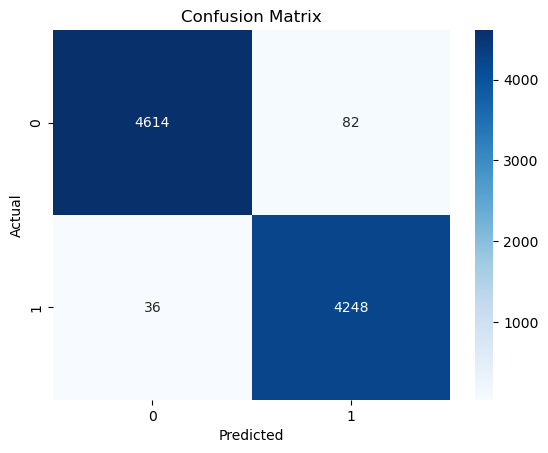

In [11]:
y_pred = pipe.predict(X_test_texts)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# 1. Dump the trained pipeline to disk
import joblib

# assume `pipe` is your fitted Pipeline
joblib.dump(pipe, 'news_classifier_pipeline.pkl')

['news_classifier_pipeline.pkl']

In [14]:
df.head()

,title,text,subject,date,label,content,cleaned_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed ‘cou...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


In [15]:
import joblib
import numpy as np

# load
pipe_loaded = joblib.load('news_classifier_pipeline.pkl')

# check class order (so you know which prob index is “REAL”)
print("Classes in order:", pipe_loaded.classes_)  
# e.g. array([0, 1]) means index 1 is “REAL”

# your new raw texts (already cleaned, or you can include cleaning step beforehand)
new_texts = [
    "Government announces new tax cuts for small businesses.",
    "Celebrity X caught in scandalous photo!",
    "Study shows drinking coffee may improve lifespan.",
]

# predict labels
preds  = pipe_loaded.predict(new_texts)
probs  = pipe_loaded.predict_proba(new_texts)

# if 1 → REAL, 0 → FAKE:
real_idx = np.where(pipe_loaded.classes_ == 1)[0][0]

for text, p, pr in zip(new_texts, preds, probs):
    label = "REAL" if p == 1 else "FAKE"
    conf  = pr[real_idx] if pr.size > real_idx else max(pr)
    print(f"{label:4s} (conf={conf:.3f}): {text}")

Classes in order: [0 1]
REAL (conf=0.743): Government announces new tax cuts for small businesses.
FAKE (conf=0.074): Celebrity X caught in scandalous photo!
FAKE (conf=0.231): Study shows drinking coffee may improve lifespan.
